Make sure you have all the packages installed:

pip3 install pandas numpy scipy matplotlib gpx-cmd-tools

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import scipy
import matplotlib.pyplot as plt
import gpxpy.geo as geo
import gpxpy
from datetime import datetime
from ast import literal_eval
import glob
from tqdm import tqdm
import requests
import urllib

%matplotlib widget

In [2]:
data_to_extract = [
    ("speed", "0x703", 0),
    ("volt", "0x702", 1),
    ("current", "0x702", 0),
    ("dist", "0x70E", 1),
    ("amp_hour", "0x70E", 0),
    ("brake", "0x250", 0),
]

to_date = np.vectorize(datetime.fromtimestamp)

#filters for a single variable from CAN dataframe, returns arrays of time and variable 
#can_id is a string like "0x232" for PACK_CURRENT from candef.json
#index is of the variable in the parsedValue array, defaults to 0 
def extract_CAN_val(df, can_id, index=0):
    that_message = df.loc[df["id"] == can_id]

    times = that_message["millis"].to_numpy() / 1000. #convert to seconds

    def get_val(x):
        parsed_array = np.array(literal_eval(x)).flatten() #converts string to array from then flattens into 1d
        return parsed_array[index]
    vars = that_message["parsedValue"].apply(get_val)

    return (times, vars)

#interpolate and format CAN dataframe into speed, accel, and current at timestep apart  
#time range is the intersection of pack_current and mccr_rpm can message time ranges
def interp_dynamics(df, timestep=0.1, smoothness=21):

    extracted_data = [extract_CAN_val(df, can_id=x[1], index=x[2]) for x in data_to_extract]

    start_time = max([message[0][0] for message in extracted_data])
    end_time = min([message[0][-1] for message in extracted_data])
    time_range = np.arange(start_time, end_time, step=timestep)

    filt_data = {
        "timestamp": time_range
    }

    for i in range(len(extracted_data)):
        times = extracted_data[i][0]
        vals = extracted_data[i][1]
        interpolator = interp1d(times, vals)
        filt_data[data_to_extract[i][0]] = interpolator(time_range)

        if(smoothness != 0):
            filt_data[data_to_extract[i][0]] = savgol_filter(filt_data[data_to_extract[i][0]], window_length=smoothness, polyorder=1)

    filt_data["accel"] = np.gradient(filt_data["speed"], time_range)
    if(smoothness != 0):
        filt_data["accel"] = savgol_filter(filt_data["accel"], window_length=smoothness, polyorder=1)

    dynamics_df = pd.DataFrame(
        filt_data, 
        index=to_date(time_range)
    )
    dynamics_df.index.name = "date"
    return dynamics_df

In [3]:
#load folder of csv into dataframe then export single csv
data_path = "./data/datalogger_fsgp2022_day1/decoded"

files = glob.glob(data_path +"/*.csv")
files = sorted(files)

full_dyn = []

from os.path import exists
if not exists(data_path + '/combined.csv'):
    for file in tqdm(files):
        if("combined.csv" in file): continue

        messages = pd.read_csv(file)
        try:
            dyn = interp_dynamics(messages)
        except Exception as e:
            print(f"error at {file}: {e}")
            continue
        full_dyn.append(dyn)

    full_dyn = pd.concat(full_dyn, sort=True)
    full_dyn.sort_index(inplace=True)

    full_dyn.to_csv(data_path + '/combined.csv', index=True)
else:
    print('combined csv already exists')

combined csv already exists


,accel,amp_hour,brake,current,dist,speed,timestamp,volt
date,,,,,,,,
2022-07-05 09:18:07.153000,0.0,0.0,0.0,0.0,-0.017870,0.0,1.657031e+09,116.176605
2022-07-05 09:18:07.253000,0.0,0.0,0.0,0.0,-0.017870,0.0,1.657031e+09,116.176301
2022-07-05 09:18:07.353000,0.0,0.0,0.0,0.0,-0.017870,0.0,1.657031e+09,116.175998
2022-07-05 09:18:07.453000,0.0,0.0,0.0,0.0,-0.017870,0.0,1.657031e+09,116.175695
2022-07-05 09:18:07.553000,0.0,0.0,0.0,0.0,-0.017870,0.0,1.657031e+09,116.175391
...,...,...,...,...,...,...,...,...
2022-07-05 18:43:44.081559,0.0,0.0,0.0,0.0,311624.691545,0.0,1.657065e+09,101.735855
2022-07-05 18:43:44.181559,0.0,0.0,0.0,0.0,311624.691545,0.0,1.657065e+09,101.737682
2022-07-05 18:43:44.281559,0.0,0.0,0.0,0.0,311624.691545,0.0,1.657065e+09,101.739508


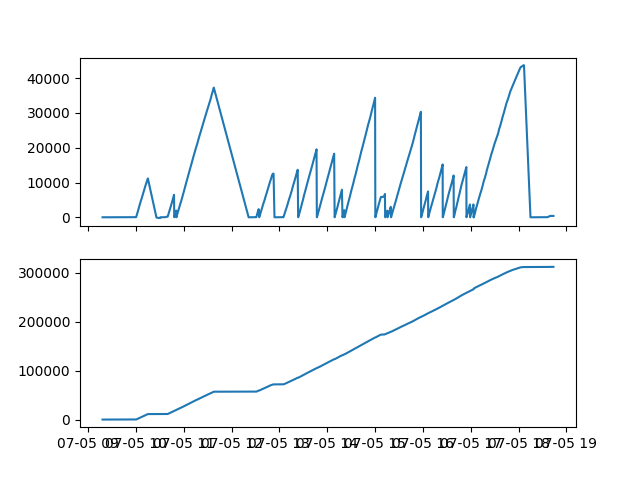

In [4]:
full_dyn = pd.read_csv('./data/datalogger_fsgp2022_day1/decoded/combined.csv', parse_dates=True, index_col=0)

last_dist = 0
dists = full_dyn.dist.values.copy()
for i in range(1, len(dists)):
    if(dists[i] < dists[i-1] - 1):
        dists[i:] = dists[i:] + dists[i-1] - last_dist
        last_dist = dists[i-1]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(full_dyn.index, full_dyn.dist)
axs[1].plot(full_dyn.index, dists)

full_dyn['dist'] = dists 
full_dyn

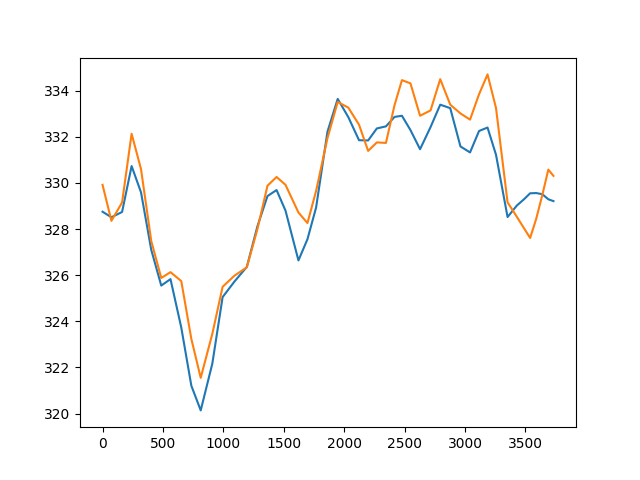

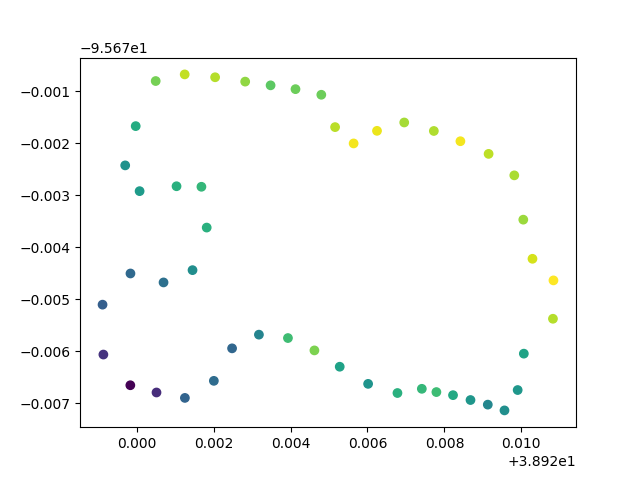

In [5]:
# Load gpx.
gpx_path = 'data/datalogger_fsgp2022_day1/heartland_track.gpx'
with open(gpx_path) as f:
    gpx = gpxpy.parse(f)

gpx.smooth(vertical=True, horizontal=False)

# Convert to a dataframe one point at a time.
points = []
for segment in gpx.tracks[0].segments:
    for i in range(450, 792, 7):
        p = segment.points[i]
        p_last = segment.points[i-1]

        slope = geo.elevation_angle(p, p_last, radians=True)

        points.append({
            'timestamp': p.time.timestamp(),
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elev_gpx': p.elevation,
            'slope': slope,
            'dist': geo.length(segment.points[450:i])
        })
df = pd.DataFrame.from_records(points)

elevations = []
for lat, lon in zip(df['latitude'], df['longitude']):
    params = {
        'output': 'json',
        'x': lon,
        'y': lat,
        'units': 'Meters'
    }
    result = requests.get(('https://nationalmap.gov/epqs/pqs.php?' + urllib.parse.urlencode(params)))
    elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
df['elev_usgs'] = elevations

plt.figure()
plt.plot(df.dist, df.elev_usgs, label='usgs')
plt.plot(df.dist, df.elev_gpx, label='gpx')

plt.figure()
plt.scatter(df.latitude, df.longitude, alpha=1, c=df.elev_gpx)
df.to_csv('data/datalogger_fsgp2022_day1/heartland_track.csv', index=False)

,accel,amp_hour,brake,current,dist,speed,timestamp,volt,slope
date,,,,,,,,,
2022-07-05 15:19:30.038775,0.533913,0.628946,0.0,38.128842,178971.515534,19.329300,1.657052e+09,105.212007,44.261884
2022-07-05 15:19:30.138775,0.510927,0.629960,0.0,36.987813,178973.458911,19.385629,1.657052e+09,105.319882,44.261004
2022-07-05 15:19:30.238775,0.486193,0.630942,0.0,35.758257,178975.408679,19.438042,1.657052e+09,105.435421,44.260122
2022-07-05 15:19:30.338774,0.460665,0.631893,0.0,34.306689,178977.364837,19.488383,1.657052e+09,105.570977,44.259236
2022-07-05 15:19:30.438774,0.434952,0.632812,0.0,32.640198,178979.327387,19.536440,1.657052e+09,105.725643,44.258348
...,...,...,...,...,...,...,...,...,...
2022-07-05 16:03:33.551666,-0.031783,1.091605,0.0,8.940611,214356.860541,11.591946,1.657055e+09,106.330677,28.244463
2022-07-05 16:03:33.651666,-0.035848,1.091832,0.0,9.124188,214358.023223,11.592511,1.657055e+09,106.313636,28.243937
2022-07-05 16:03:33.751666,-0.038480,1.092048,0.0,9.197954,214359.186160,11.593735,1.657055e+09,106.306708,28.243410


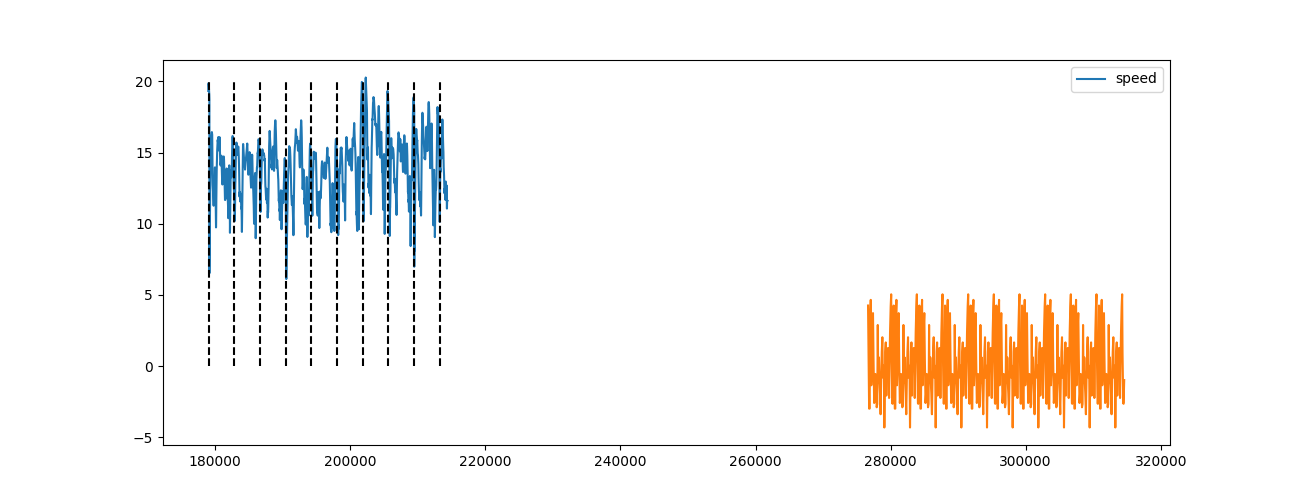

In [12]:
[plt.close(fig) for fig in list(map(plt.figure, plt.get_fignums()))]
# STARTTIME = datetime.strptime('2022-07-05 15:23:00', '%Y-%m-%d %H:%M:%S')
STARTTIME = datetime.strptime('2022-07-05 15:19:30', '%Y-%m-%d %H:%M:%S')
ENDTIME   = datetime.strptime('2022-07-05 16:03:34', '%Y-%m-%d %H:%M:%S')
dyn = full_dyn.truncate(STARTTIME, ENDTIME)

plt.figure(figsize=(13, 5))
plt.plot(dyn.dist, dyn.speed, label='speed')

dists = dyn.dist.values

track_len = 3800
num_laps = 10

track_info = pd.read_csv('data/datalogger_fsgp2022_day1/heartland_track.csv')
slopes = np.tile(track_info.slope.values, num_laps)
slope_dists = np.zeros_like(slopes)
n = len(track_info.slope.values)
for i in range(num_laps):
    slope_dists[i*n:(i+1)*n] = track_info.dist.values + track_len*i

laps = np.arange(dists[0], dists[-1], step=track_len) + 50

plt.vlines(x=laps, ymin=0, ymax=20, linestyles='dashed', colors='k')
plt.plot(slope_dists + 280460 - 3800, slopes*100)

slope_interp = interp1d(slope_dists + 280460 - 3800, slopes, fill_value='extrapolate')

dyn['slope'] = slope_interp(dists)

# plt.plot(dists, dyn.slope*100, label='slope*100')
plt.legend()

dyn

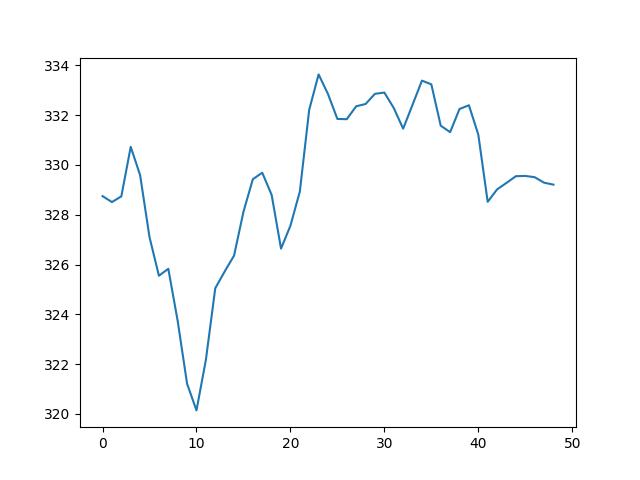

In [9]:
plt.figure()
plt.plot(track_info.elev_usgs)

power_coeffs: [0.01511, 2.46318, 170.98466, 376.202]
estimated watt-hours:  2858.80954449181
actual watt-hours:  2753.704073688954
r_squared_watts: 0.6828641793237811


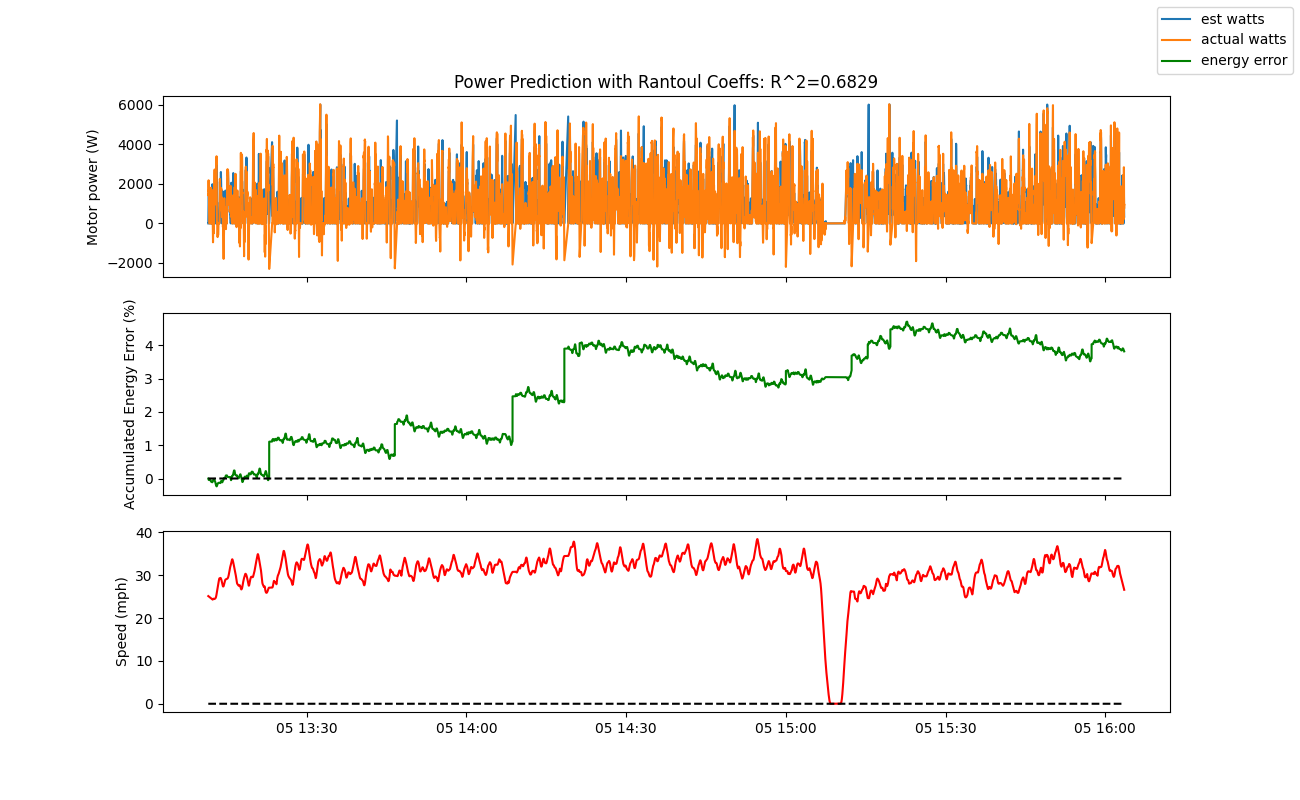

In [13]:
def power_lsq(accels, car_speeds, wind_speeds, currents, voltages, slopes, brake_statuses):
    
    A_T = np.array([
        (car_speeds + wind_speeds)**3,
        car_speeds**2,
        # car_speeds,
        np.ones_like(car_speeds),
        # accels,
        # np.multiply(np.clip(accels, -0.5, 1), car_speeds),
        # np.multiply(np.clip(accels, -1, -0.5), car_speeds),
        np.multiply(accels, car_speeds),
        # currents,
        # voltages,
        # np.multiply(car_speeds, np.sin(slopes)),
    ])
    A = A_T.T
    b = np.multiply(currents, voltages)
    x_star = np.linalg.lstsq(A, b, rcond=None)[0]
    return A, x_star #estimated_currents = A @ x_star

STARTTIME = datetime.strptime('2022-07-05 13:11:30', '%Y-%m-%d %H:%M:%S')
ENDTIME   = datetime.strptime('2022-07-05 16:03:34', '%Y-%m-%d %H:%M:%S')
test_dyn = full_dyn.truncate(STARTTIME, ENDTIME)

zeros = np.zeros_like(dyn.speed.values)
test_zeros = np.zeros_like(test_dyn.speed.values)

dyn_data, power_coeffs = power_lsq(dyn.accel.values, dyn.speed.values, zeros, dyn.current.values, dyn.volt.values, dyn.slope.values, zeros)
test_dyn_data, _ = power_lsq(test_dyn.accel.values, test_dyn.speed.values, test_zeros, test_dyn.current.values, test_dyn.volt.values, test_zeros, test_zeros)

#rantoul coefficients, comment out to generate coefficients from portion of fsgp data
power_coeffs = [0.01511,  2.46318,  170.98466,  376.202]

print(f"power_coeffs: {power_coeffs}")


est_powers = test_dyn_data @ power_coeffs
est_powers = np.clip(est_powers, 0, 6000)
act_powers = np.multiply(test_dyn.current.values, test_dyn.volt.values)
# act_powers = np.clip(act_powers, 0, 6000)


for i in range(len(test_dyn.speed.values)):
    if (np.abs(test_dyn.speed.values[i]) < 0.5):
        est_powers[i] = 0

est_energy = scipy.integrate.cumtrapz(est_powers, test_dyn.timestamp)
act_energy = scipy.integrate.cumtrapz(act_powers, test_dyn.timestamp)
print("estimated watt-hours: ", est_energy[-1]/3600.)
print("actual watt-hours: ", act_energy[-1]/3600.)

avg_watts = np.mean(act_powers)
r_squared_watts = 1 - ((act_powers - est_powers)**2).sum() / ((act_powers - avg_watts)**2).sum()
print(f"r_squared_watts: {r_squared_watts}")

fig, axs = plt.subplots(3, 1, figsize=(13, 8), sharex=True)
axs[0].plot(test_dyn.index, est_powers, label='est watts')
axs[0].plot(test_dyn.index, act_powers, label='actual watts')
axs[0].set(ylabel="Motor power (W)")
axs[0].set_title(f"Power Prediction with Rantoul Coeffs: R^2={np.round(r_squared_watts, 4)}")

axs[1].plot(test_dyn.index[:-1], (est_energy - act_energy)/act_energy[-1] * 100, 'g', label='energy error')
axs[1].plot(test_dyn.index[:-1], np.zeros(len(test_dyn.index[:-1])), 'k--')
axs[1].set(ylabel="Accumulated Energy Error (%)")

axs[2].plot(test_dyn.index, savgol_filter(test_dyn.speed.values, 1001, 1)*2.23694, 'r')
axs[2].plot(test_dyn.index, np.zeros(len(test_dyn.index)), 'k--')
axs[2].set(ylabel="Speed (mph)")

fig.legend()

p_forward: [1.11931595e+00 1.20505715e+03]
p_backward: [ 2.47736377e-01 -2.84728857e+02]


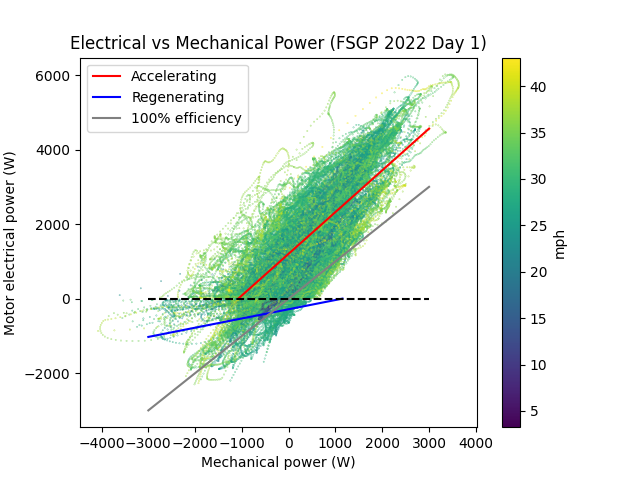

In [14]:
dyn_forward = test_dyn.loc[((test_dyn['current']) > 0.2) & (np.abs(test_dyn['accel'] < 1)) & (np.abs(test_dyn['speed'] > 1))]
dyn_backward = test_dyn.loc[((test_dyn['current']) < -0.2) & (np.abs(test_dyn['accel']) < 1) & (np.abs(test_dyn['speed'] > 1))]

mass = 250
power_pred_forward = dyn_forward.accel*dyn_forward.speed * mass
power_pred_backward = dyn_backward.accel*dyn_backward.speed * mass

p_forward = np.polyfit(power_pred_forward, dyn_forward.current*dyn_forward.volt, 1)
p_backward = np.polyfit(power_pred_backward, dyn_backward.current*dyn_backward.volt, 1)


plt.figure()
plt.scatter(power_pred_forward, dyn_forward.current*dyn_forward.volt, alpha=1, s=0.05, c=dyn_forward.speed * 2.23694)
plt.scatter(power_pred_backward, dyn_backward.current*dyn_backward.volt, alpha=1, s=0.05, c=dyn_backward.speed * 2.23694)

x = np.linspace(-p_forward[1]/p_forward[0], 3000, 10)
plt.plot(x, p_forward[0]*x + p_forward[1]*x**0, 'r', label='Accelerating')

x = np.linspace(-3000, -p_backward[1]/p_backward[0], 10)
plt.plot(x, p_backward[0]*x + p_backward[1]*np.ones_like(x), 'b', label='Regenerating')

x = np.linspace(-3000, 3000, 100)
plt.plot(x, x, 'gray', label='100% efficiency')
plt.plot(x, np.zeros_like(x), 'k--')

cbar = plt.colorbar()
cbar.set_label('mph')
plt.xlabel('Mechanical power (W)')
plt.ylabel('Motor electrical power (W)')
plt.legend()

plt.title('Electrical vs Mechanical Power (FSGP 2022 Day 1)')

print(f"p_forward: {p_forward}")
print(f"p_backward: {p_backward}")

p_forward: [   0.55321925 -390.89555628]
p_backward: [   0.86162176 -282.33067786]


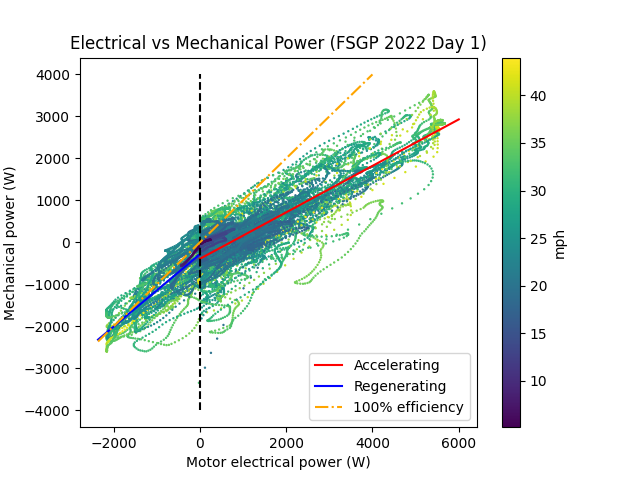

In [ ]:
# dyn_forward = test_dyn.loc[((test_dyn['current']) > 0.2) & (np.abs(test_dyn['accel'] < 1)) & (np.abs(test_dyn['speed'] > 1))]
# dyn_backward = test_dyn.loc[((test_dyn['current']) < -0.2) & (np.abs(test_dyn['accel']) < 1) & (np.abs(test_dyn['speed'] > 1))]

dyn_forward = dyn.loc[((dyn['current']) > 0.2) & (np.abs(dyn['accel'] < 1)) & (np.abs(dyn['speed'] > 1))]
dyn_backward = dyn.loc[((dyn['current']) < -0.2) & (np.abs(dyn['accel']) < 1) & (np.abs(dyn['speed'] > 1))]

power_pred_forward = dyn_forward.current*dyn_forward.volt
power_pred_backward = dyn_backward.current*dyn_backward.volt

mass = 250
p_forward = np.polyfit(power_pred_forward, dyn_forward.accel*dyn_forward.speed * mass, 1)
p_backward = np.polyfit(power_pred_backward, dyn_backward.accel*dyn_backward.speed * mass, 1)


plt.figure()
plt.scatter(power_pred_forward, dyn_forward.accel*dyn_forward.speed * mass, alpha=1, s=0.5, c=dyn_forward.speed * 2.23694)
plt.scatter(power_pred_backward, dyn_backward.accel*dyn_backward.speed * mass, alpha=1, s=0.5, c=dyn_backward.speed * 2.23694)

x = np.linspace(0, 6000, 10)
plt.plot(x, p_forward[0]*x + p_forward[1]*x**0, 'r', label='Accelerating')

x = np.linspace(-2360, 0, 10)
plt.plot(x, p_backward[0]*x + p_backward[1]*np.ones_like(x), 'b', label='Regenerating')

y = np.linspace(-4000, 4000, 100)
plt.plot(np.zeros_like(y), y, 'k--')

x = np.linspace(-2360, 4000, 100)
plt.plot(x, x, 'orange', linestyle='dashdot', label='100% efficiency')


cbar = plt.colorbar()
cbar.set_label('mph')
plt.ylabel('Mechanical power (W)')
plt.xlabel('Motor electrical power (W)')
plt.legend()

# plt.ylim(-4000, 4000)
# plt.xlim(-2360, 6000)

plt.title('Electrical vs Mechanical Power (FSGP 2022 Day 1)')

print(f"p_forward: {p_forward}")
print(f"p_backward: {p_backward}")

In [ ]:
dyn_forward

,accel,amp_hour,brake,current,dist,speed,timestamp,volt,slope
date,,,,,,,,,
2022-07-05 15:20:11.125047,0.148937,2.909131,0.0,0.105048,281061.877791,14.959498,1.657060e+09,102.410312,0.010627
2022-07-05 15:20:11.225047,0.157970,2.909172,0.0,0.333616,281063.373990,14.971549,1.657060e+09,102.377820,0.011146
2022-07-05 15:20:11.325047,0.168280,2.909225,0.0,0.720470,281064.871403,14.985211,1.657060e+09,102.329260,0.011666
2022-07-05 15:20:11.425047,0.179189,2.909291,0.0,1.271722,281066.370031,14.999868,1.657060e+09,102.265293,0.012186
2022-07-05 15:20:11.525047,0.191082,2.909368,0.0,1.878772,281067.869873,15.014309,1.657060e+09,102.196197,0.012707
...,...,...,...,...,...,...,...,...,...
2022-07-05 16:03:31.765255,-0.135506,8.163606,0.0,0.117606,310816.009921,0.184828,1.657062e+09,101.434265,0.008658
2022-07-05 16:03:31.865255,-0.137537,8.163610,0.0,0.058986,310816.018700,0.167800,1.657062e+09,101.436918,0.008665
2022-07-05 16:03:31.965255,-0.138934,8.163612,0.0,0.019717,310816.025768,0.148876,1.657062e+09,101.439244,0.008671


-0.001870638091436368


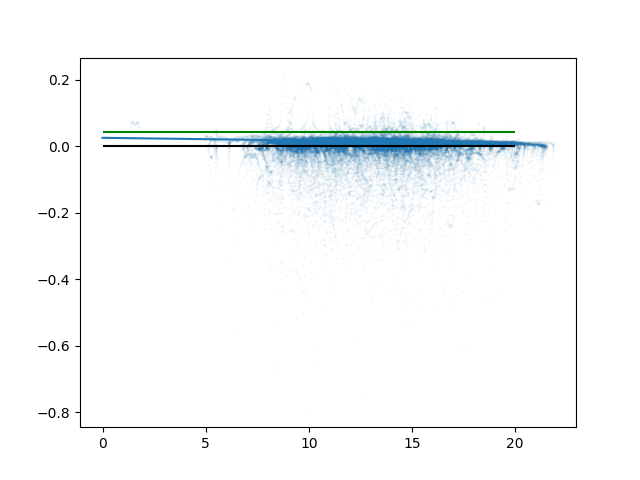

In [ ]:
dyn_accel = test_dyn.loc[(test_dyn['current'] > 1) & (np.abs(test_dyn['accel']) < 1)]
plt.figure()
plt.hlines(y=0, xmin=0, xmax=20, colors='k')
plt.hlines(y=0.0414437, xmin=0, xmax=20, colors='g')
# torques = 2.833 
plt.scatter(dyn_accel.speed, dyn_accel.accel/dyn_accel.current, s=0.1, alpha=0.1)

x = np.linspace(0, 20, 10)
plt.plot(x, -0.00080924*(x-19.53)+0.00958)

print(np.mean(dyn_accel.accel/dyn_accel.current))
